# The sound Of Hydrogen

Inspired by [minutephysics](https://www.youtube.com/watch?v=qyi5SvPlMXc), and the explanation do do it in mathematica: [The sound of hydrogen](https://www.youtube.com/watch?v=IhvW8yZdE5A).

The goal of this notebook is to show how one can play a sound file in notebook, using Html5 &lt;audio&gt; tag to play it dirrectly inside the browser.

To do this we use the  spectrum of hydrogen that we shift the into the audible range. You can listen to it in the last cell of this notebook.
Wait a few second if you are on nbviewer, the notebook is not light (someone to update it to use mp3? ogg? or a compressed format?)

Please be aware that the html5 player is not working on some old browser and IE.

\[Edit\] apparently the process of converting something not audible into sound have diffent naming: sonify,
sonification or auralizing according to the comment on twitter.

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function, absolute_import
import scipy.constants as const
import numpy as np
import scipy

from matplotlib.pyplot import plot
from scipy.io import wavfile
from IPython.core.display import HTML, display

In [3]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it
# 
# note that this is not needed anymore in recent version of IPython and SciPy.
import sys
if sys.version_info < (3,):
    from StringIO import StringIO as BytesIO
else:
    from io import BytesIO
import base64

def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    
    Adapted from SciPy.io.
    """
    
    buffer = BytesIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
#    return buffer.getvalue()
    # Determine file size and place it in correct
    #  position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))

Update notes, the above is not need anymore as IPython now provide the "Audio" object.

In [4]:
try:
    from IPython.display import Audio
    def wavPlayer(data, rate):
        display(Audio(data, rate=rate))
except ImportError:
    pass

In [5]:
## some consstant for our audio file 
from numpy import sin, pi
rate = 44100 #44.1 khz
duration =2.5 # in sec

# this will give us sin with the righ amplitude to use with wav files
normedsin = lambda f,t : 2**13*sin(2*pi*f*t)

time = np.linspace(0,duration, num=rate*duration)

# Test the wav Player

let's try to first just play an A (440 Hz).

In [6]:
import numpy
import struct
import warnings    

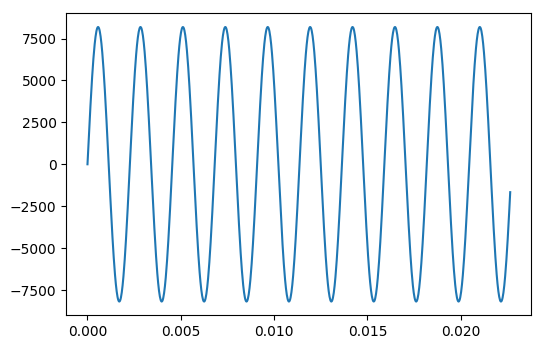

In [7]:
# define A as a 440 Hz sin function 
la    = lambda t : normedsin(440,t)

# look at it on the first 25 ms
plot(time[0:1000], la(time)[0:1000])

ampl = la(time).astype(np.int16)

# write the file on disk, and show in in a Html 5 audio player
wavPlayer(ampl, rate)

The differents frequencies emmited by an hydrogen atom is given by the rydberg formulae :

$$ {1 \over \lambda}  = R \left({1\over n_1}-{1\over n_2}\right) $$

Which gives a similar relation on the emitted frequencies of the Hydrogen :

$$ f_{n,m}={c \over \lambda}  = {R_h\over h} \left({1\over n}-{1\over m}\right) $$

for $n=1$ we've got the Lyman series, and for $n=2$ we have the Balmer series

In [8]:
# fondamental frequency of hydrogen
f0 = const.Rydberg*const.c
print("The highest frequency of hydrogen is ",f0,"Hz. and correspond to n = 1, m = ∞")
fshift = 440
print("we can shift the spectrum for it to be at 440 Hz (A)")

The highest frequency of hydrogen is  3289841960355208.5 Hz. and correspond to n = 1, m = ∞
we can shift the spectrum for it to be at 440 Hz (A)


In [9]:
ryd = lambda n,m : fshift*(1/(n**2) -1/(m**2))
flyman = lambda x : ryd(1,x)
fbalmer = lambda x : ryd(2,x)

In [10]:
## define the sum, 
ser = lambda t : sum( [normedsin(flyman(i),t)+normedsin(fbalmer(i+1),t) for i in range(2,8)])

# and a verorialized function to work on a by element basis with matlab
serv = scipy.vectorize(ser)

In [11]:
ss = serv(time)

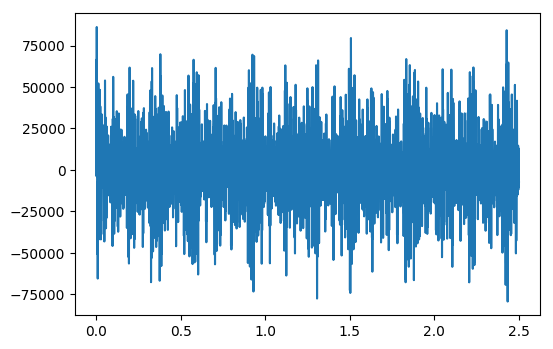

In [12]:
plot(time,ss)
ss = 2**15*ss/ ss.max()

In [13]:
#wavfile.write('hydrogen.wav', rate, ss.astype(np.int16))
wavPlayer(ss.astype(np.int16),rate)

As always, Pull-Request and comment to fix typo and any other things are welcommed on [github](https://github.com/Carreau/posts).